# MakeMore Part 3: Activations & Gradients, BatchNorm
* To understand more complex architectures, we need to go back to MLPs and build an intuitive understanding of activations and gradients
* Especially how gradients behave and look like
* Recurring Neural Networks are very expressive in that they are an universal approximator and can in principle implement all the algorithms
* But RNNs are not very easily optimizable with the first-order gradient based techniques that we have available to us
* The key to understanding, why they are not easily optimizable is the behavior of the activations and the gradients and how they behave during training
* We will see that a lot of the variants since RNNs have tried to improve on that situation

## The (cleaned-up) MLP Code

In [94]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [96]:
len(words)

32033

In [97]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(stoi)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [98]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

print(len(words))
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

32033
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


* The parameter initialization is cleaned-up a bit, as the magic numbers are removed and turned into variables

In [99]:
# MLP revisited
def initParams():
    global g, C, W1, b1, W2, b2, parameters
    n_embd = 10 # the dimensionality of the character embedding vectors
    n_hidden = 200 # the number of neurons in the hidden layer of the MLP
    
    g = torch.Generator().manual_seed(2147483647) # for reproducibilityrandom.shuffle(words)
    C = torch.randn((vocab_size, n_embd),           generator=g)
    W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,                      generator=g)
    W2 = torch.randn((n_hidden, vocab_size),        generator=g)
    b2 = torch.randn(vocab_size,                    generator=g)
    
    parameters = [C, W1, b1, W2, b2]
    print(sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True

* Training of the net

In [100]:

def train():
    # same optimization as last time
    max_steps = 200000
    batch_size = 32
    global lossi
    lossi = []
    global logits
    global hpreac
    
    for i in range(max_steps):
        
        # minibatch construct
        xi = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[xi], Ytr[xi]                                              # batch X,Y
    
        # forward pass
        emb = C[Xb]                                                            # embed the charaters into vectors
        embcat = emb.view(emb.shape[0], -1)                                    # concatenate the vectors
        hpreac = embcat @ W1 + b1                                              # hidden layer pre-activation
        h = torch.tanh(hpreac)                                                 # hidden layer
        logits = h @ W2 + b2                                                   # output layer
        loss = F.cross_entropy(logits, Yb)                                     # loss function
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # update
        lr = 0.1 if i < 100000 else 0.01                                       # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad
    
        # track stats
        if i % 10000 == 0:                                                     # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

        lossi.append(loss.log10().item())    

In [101]:
initParams()
train()

11897
      0/ 200000: 27.8817
  10000/ 200000: 2.8341
  20000/ 200000: 2.5523
  30000/ 200000: 2.8717
  40000/ 200000: 2.0855
  50000/ 200000: 2.5842
  60000/ 200000: 2.4150
  70000/ 200000: 2.1321
  80000/ 200000: 2.3674
  90000/ 200000: 2.3077
 100000/ 200000: 2.0464
 110000/ 200000: 2.4816
 120000/ 200000: 1.9383
 130000/ 200000: 2.4820
 140000/ 200000: 2.1662
 150000/ 200000: 2.1765
 160000/ 200000: 2.0685
 170000/ 200000: 1.7901
 180000/ 200000: 2.0546
 190000/ 200000: 1.8380


* Plot the loss of batch per iteration

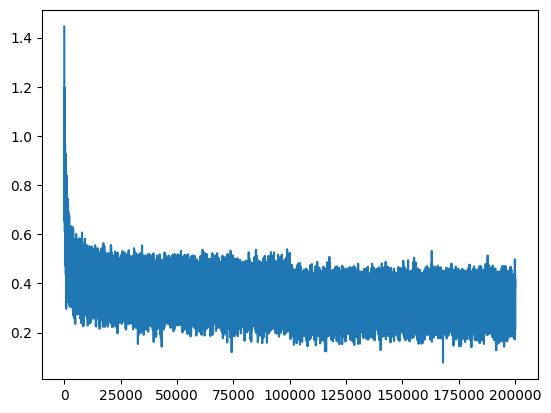

In [102]:
plt.plot(lossi)

* Print training and validation loss for the full splits

In [103]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.125401020050049
val 2.1713311672210693


* Sample from the trained model

In [104]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context  = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nah.
yam.
rensleighdrae.
caileed.
elin.
shy.
jen.
eden.
estanaraelyn.
malke.
cayshuberlyni.
jest.
jair.
jenipanthono.
ubelleda.
kylynn.
els.


## Better Initialization of the Parameters
* The first line printed while training was ```0 / 200000: 27.8817```
* It comes rapdidly down to $2$, so we can tell that the initial loss is way too high
* In training of NN it is almost always the case that we will have a rough idea of what loss to expect at initialization
* That depends on the loss function and the problem setup
* In this case we expect a much lower number and we can calculate that
* In our problem, there are 27 characters that could come next for any one training example
* There is no reason to believe any character would come more likely than the others
* So we would expect that the probability distribution that comes out initially is the uniform distribution
* This means that any character should have a probability of roughly $1/27$ and the loss is the negative log probability

In [105]:
-torch.tensor(1/27).log()

tensor(3.2958)

* So we would expect a loss of $3.29$
* Drawing the initial probabilities from the random distribution will give high probability to the wrong characters

### Example for 4 Characters

* Let's imagine we only have 4 characters with a very wrong distribution, i.e. high numbers assigned to the wrong character and a low number to the right one

In [106]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

* When all predictions are equal, i.e. form a diffuse distribution as above, the probabilities will all be equal and we'd expect a loss of $1.3$
* As the logits will start to change, the loss will change, too

In [107]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

* If by chance the correct character received a high logit value, the loss will be low

In [108]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

* But is is more likely that some other logit will receive a high value and then we will record a much higher loss

In [109]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

* If the logits go to more extreme values, it is more unlikely to pick the correct one and the loss will become even higher

In [110]:
logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([4.5540e-29, 0.0000e+00, 1.0000e+00, 0.0000e+00]), tensor(-0.))

* So we want the logits to be roughly equal when the network is initialized

In [111]:
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

### Where Things went wrong at our Initialization

* We will break after the first iteration and look at the logits

In [134]:
def trainOnce():
    # same optimization as last time
    max_steps = 200000
    batch_size = 32
    global h
    global lossi
    lossi = []
    global logits
    global hpreac
    
    for i in range(max_steps):
        # minibatch construct
        xi = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[xi], Ytr[xi]                                              # batch X,Y
    
        # forward pass
        emb = C[Xb]                                                            # embed the charaters into vectors
        embcat = emb.view(emb.shape[0], -1)                                    # concatenate the vectors
        hpreac = embcat @ W1 + b1                                              # hidden layer pre-activation
        h = torch.tanh(hpreac)                                                 # hidden layer
        logits = h @ W2 + b2                                            # output layer
        loss = F.cross_entropy(logits, Yb)                                     # loss function
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # update
        lr = 0.1 if i < 100000 else 0.01                                       # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad
    
        # track stats
        if i % 10000 == 0:                                                     # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
        break    
        

In [135]:
initParams()
trainOnce()

11897
      0/ 200000: 27.8817


In [114]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

* We can see that the logits in the first row take on extreme values
* This is what creates the fake confidence in incorrect answers and make the loss get high
* So these logits should be much closer to zero
* Let's see how we can achieve this

### Changing the Parameter Initialization
* All parameters are initialized randomly
* We start at the end and see that we shouldn't add anything at the end, i.e. set ```b2``` to zero
* Also we will scale down the ```W2``` weights by a factor of $0.01$

In [115]:
# MLP revisited
def initParamsZero():
    global g, C, W1, b1, W2, b2, parameters
    n_embd = 10
    n_hidden = 200
    
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((vocab_size, n_embd),           generator=g)
    W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
    b1 = torch.randn(n_hidden,                      generator=g)
    W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01         # Scale down W1 weights
    b2 = torch.randn(vocab_size,                    generator=g) * 0            # Initialize b2 to all zeros
    
    parameters = [C, W1, b1, W2, b2]
    print(sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad = True

* We'll explain in a second why we cannot set the ```W2``` weights to exactly zero

In [139]:
initParamsZero()
trainOnce()

11897
      0/ 200000: 3.3221


* The loss is now close enough, but not exactly what we would get from a uniform distribution
* This is because our weights have some entropy, which will be used for symmetry breaking as we'll see in a minute
* The logits will now come out much closer to zero

In [117]:
logits[0]

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

* Now let's train normally again and check the losses

In [118]:
initParamsZero()
train()

11897
      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


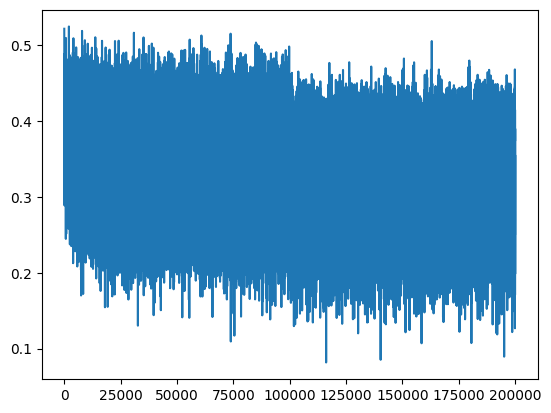

In [119]:
plt.plot(lossi)

* The plot of the loss doesn't have this hockey stick shape anymore
* What happens in the hockey stick shape is that the network first squashes down the logits and then rearranges them
* The squashing is an easy gain for the network
* We just removed the squashing step from the training and the network only does the hard work
* We can now see that the final loss has improved

In [120]:
split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310746669769287


## The Problem with the hidden Layer Output
* The problem lies within the activations of the hidden state ```h``` in our training code

In [121]:
initParamsZero()
trainOnce()

11897
      0/ 200000: 3.3221


In [122]:
h

tensor([[-0.0504, -1.0000,  0.3704,  0.8300,  0.9995,  0.6944,  0.8911, -0.9996,
         -0.9964,  0.9984, -0.9210, -0.9605,  0.9995,  1.0000,  0.0018, -0.9804,
          0.9967, -0.9574, -0.9999,  1.0000,  0.9878,  0.9728, -0.3850,  0.8521,
          0.9817, -0.9934,  0.5901, -0.9994,  0.9996,  0.8462, -0.9373, -0.9790,
          0.9810, -0.9752, -0.9289, -0.9780, -0.7851, -0.5193, -0.9967,  0.2163,
          0.9552, -0.6758, -0.6397, -0.9948, -0.9965, -0.9984, -0.9993,  0.6283,
          0.2169, -0.9330, -0.9649, -0.9941, -0.8352,  0.9988, -0.9995, -0.9965,
          0.2963,  1.0000, -0.9995,  0.9941, -0.9639,  0.9995,  0.9195, -1.0000,
          1.0000,  0.7321,  0.9724, -0.9994, -0.9999, -0.9967, -0.6345, -0.3183,
          0.9576, -0.6941, -0.9983, -0.9980, -0.0811, -0.9959, -0.9184,  0.9845,
          0.9997,  0.9986,  0.9980,  0.4210,  0.9997, -0.3293,  0.9718,  0.8664,
         -0.9672, -0.3906,  0.9999,  0.9999, -0.9984,  0.3939, -0.9111, -0.9999,
          0.9995,  0.9982,  

* We can see that many elements are $1.0$ or $-1.0$
* Recall that $tanh$ is a squashing function
* It takes arbitrary numbers and squashes them into a range of $1.0$ and $-1.0$ and it does this smoothly

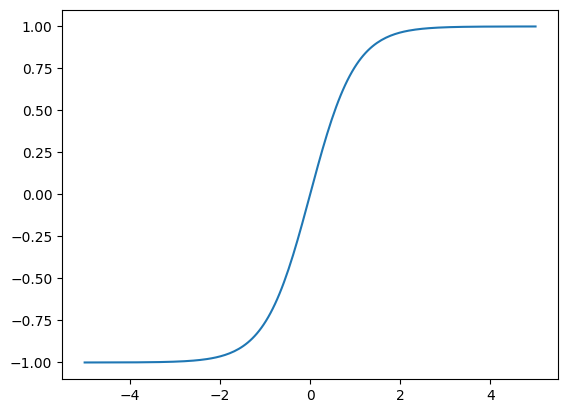

In [123]:
tanh_domain = torch.linspace(-5, 5, 200)
tanh_range = torch.tanh(tanh_domain)
plt.plot(tanh_domain, tanh_range)

* Let's look at the histogram of $h$ to get a feeling for the distribution of these values

In [124]:
h.shape

torch.Size([1, 200])

* We have 32 samples and 200 activations
* We can view it as -1 and stretch it out into one large vector and convert it to a python list
* Then we plot it as a histogram with 50 bins

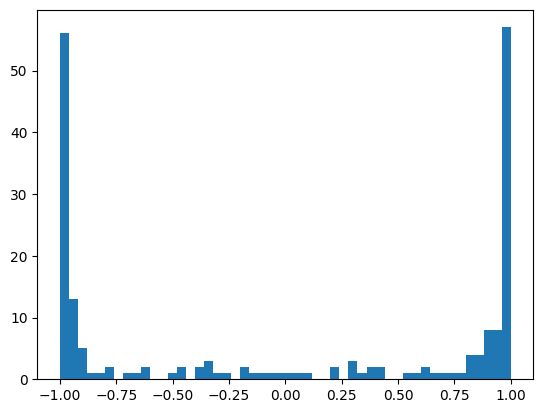

In [125]:
plt.hist(h.view(-1).tolist(), 50);

* Most of the values by far are at $1.0$ and $-1.0$, so this tanh is very active
* We can also look at the preactivations that feed into the tanh

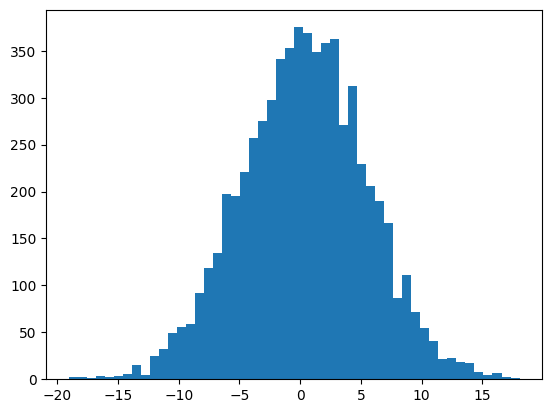

In [126]:
plt.hist(hpreac.view(-1).tolist(), 50);

* We can see that the distribution of the preactivations is very broad
* This is why so many values outside $-2.0$ and $2.0$ get squashed to $-1.0$ and $1.0$
* We will understand the problem with this activation, once we understand how gradients flow through the NN

### The Problem during Backpropagation
* The hidden layer is computed as
  
    ```h = torch.tanh(hpreact)```

* The layer is made up of 200 neurons for each one of the samples and the layer implements an element-wise tanh
* Let's look at what happens with tanh in the backward pass
* When we implemented micrograd in the first lecture, the backpropagation for tanh looked as follows

  ```
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1) 
        out = Value(t, (self, ), 'tanh')
        def backward():
            self.grad += (1-t**2)*out.grad
        out._backward = backward
        return out
  ```
* The backward pass computes the gradient with the formula $(1-t^2)*out.grad$, where $t$ is $tanh$ itself
* if $tanh$ is $-1.0$ or $1.0$, then the whole expression becomes zero no matter what $out.grad$ is
* The gradient will basically be destroyed at a $tanh$ node with activations farther than 1 from 0
* Looking at an activation of exactly zero, the term $(1-t^2)$ will become exactly $1.0$ and the gradient is just passed through
* So going from zero into the positive or negative direction will only ever decrease the gradient until it vanishes

### The dead Neuron

* Remember that h contains the activations for all samples (the rows) and how those samples activate each of the 200 neurons (the columns)
* Each sample activates the neurons differently and might cause the neuron's activation to land in the flat part of tanh, yielding -1 or 1 as the output
* In this case, the weights of the neuron will not be changed during gradient descent
* If for a specific neuron all samples will make the neuron's output to land in the flat part, then that neuron will never learn and is called a *dead neuron*
* Let's inspect the hidden layer output ```h``` for dead neurons

In [136]:
h.shape

torch.Size([32, 200])

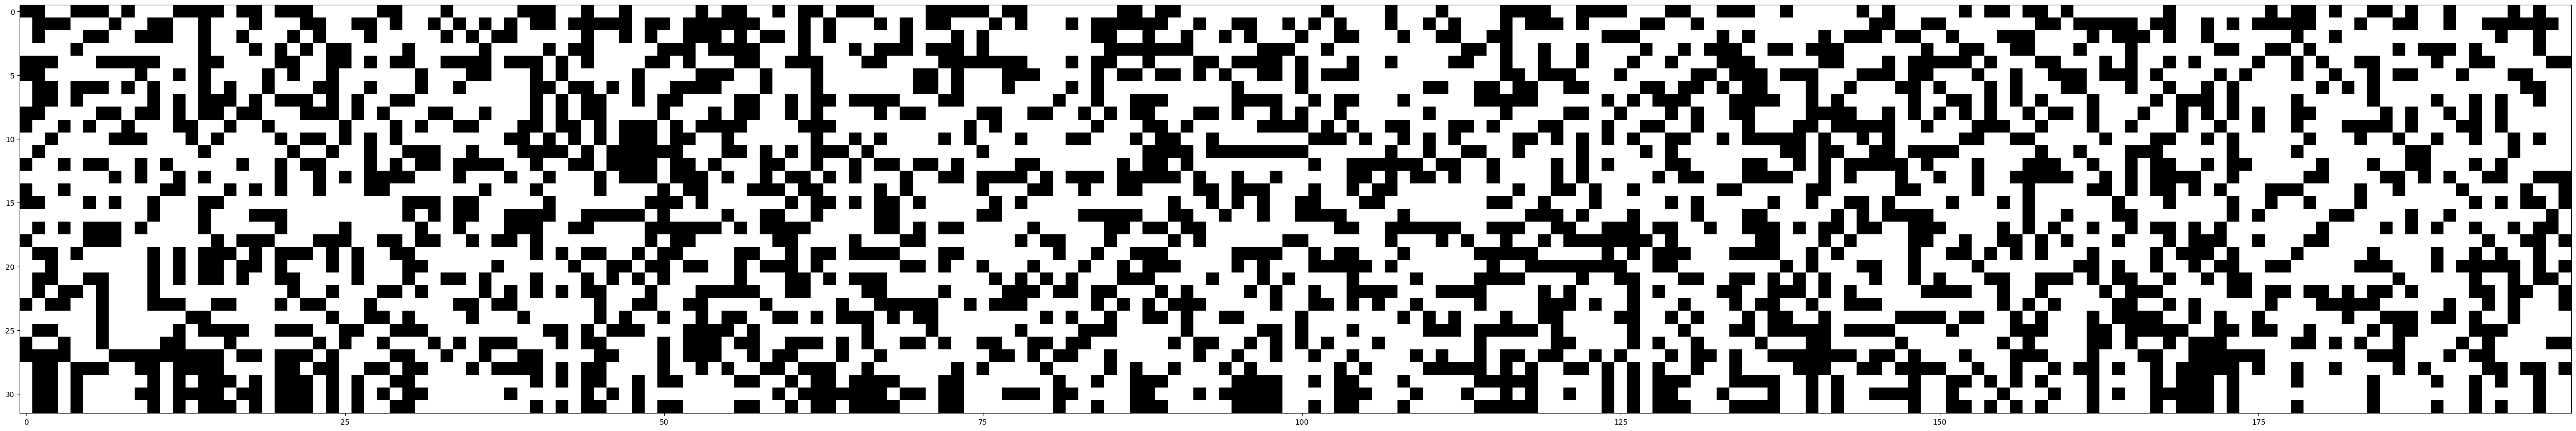

In [137]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

* We don't see a completely white column in the last iteration and last batch
* So every neuron will learn something from the batch
* The dead neuron effect might also happen with other non-linearities

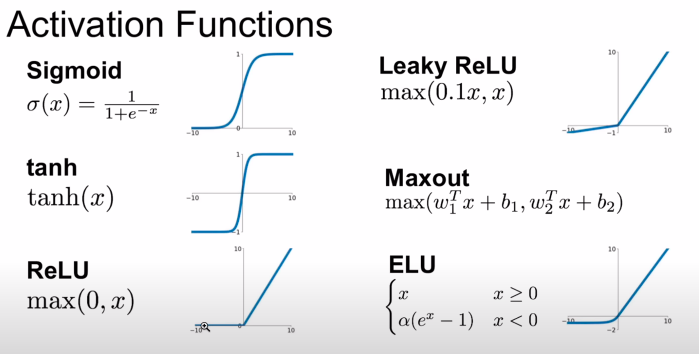

* Sigmoid is also a squashing neuron and will have the same problem
* ReLU will have a derivative of 0 below 0 and 1 above zero ($f(x)=x$, so $\frac{df}{dx}=1$, for $x > 0$)
* So if a ReLU neuron never activates for a given training set, it will never learn
* Leaky ReLU doesn't have a flat tale, so it will not suffer from this issue as much
* ELU again has flat parts, so it might suffer from this issue

* In summary, dead neurons might happen at initialization, which we can avoid (shown in the next section)
* But dead neurons can even happen during training
* If you have a too high learning rate for example, some neurons might get to high of a gradient and get knocked out off the ??? manifold
* 

## Avoid dead Neurons at Initialization
* Coming back to the preactivations after initialization, we can see the the values are spread out too extreme

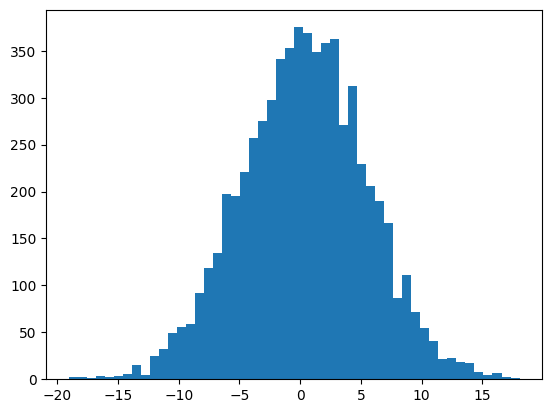

In [140]:
plt.hist(hpreac.view(-1).tolist(), 50);

* All values outside of $(-1,1)$ will be squashed to $-1$ and $1$ respectively and will land in the flat zone of $tanh$
* For all those values the network will not update the neuron
* We want most of the preactivations to land in the right range, so backprop will have an effect on that neuron